In [1]:
%load_ext autoreload
%autoreload 2

In [66]:
import pandas as pd
import numpy as np
import glob # lista di files in formato *.estensione
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [5]:
PATH_DATA = "./PhonePi/data/"
FILES = glob.glob(PATH_DATA+"*") # lista di tutte le immagini nella cartella
FILES[0:2]

['./PhonePi/data\\bus', './PhonePi/data\\bus.txt']

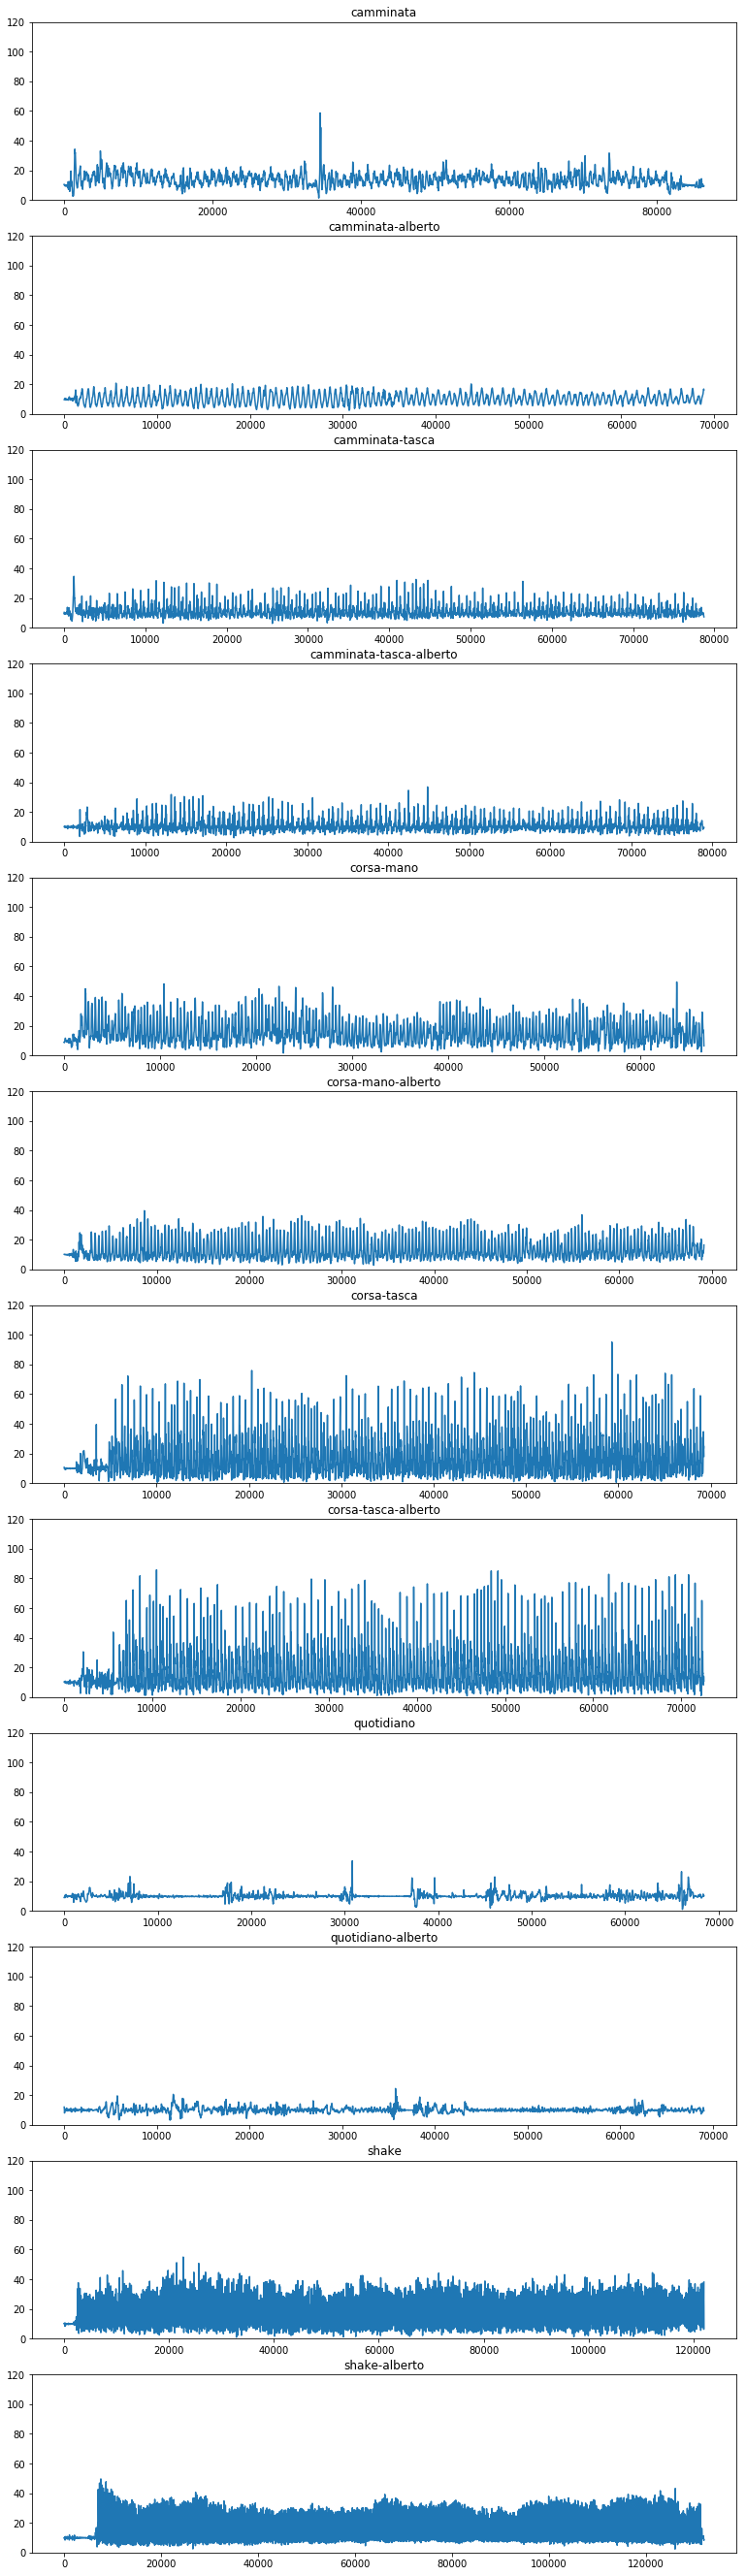

In [94]:
PATH_DATA = './PhonePi/data/'
DIR = [os.path.join(PATH_DATA, o) for o in os.listdir(PATH_DATA) 
                    if os.path.isdir(os.path.join(PATH_DATA,o))]

plt.figure(figsize=(13,4*len(DIR)))
nrow = len(DIR)
for i in range(len(DIR)):
    data = pd.read_csv(DIR[i] + "/accelerometer.txt", names = ["user", "type", "t", "ax", "ay", "az"])
    data.truncate(before = 600, after = 7000)
    data["t"] = data["t"] - data["t"].iloc[0]
    data["a"] = (data["ax"]**2 + data["ay"]**2 + data["az"]**2)**0.5
    ax = plt.subplot(nrow, 1, i+1, ylim=(0,120))
    ax.set_title(DIR[i].split("/")[-1])
    plt.plot(data["t"],data["a"], )
    
plt.show()

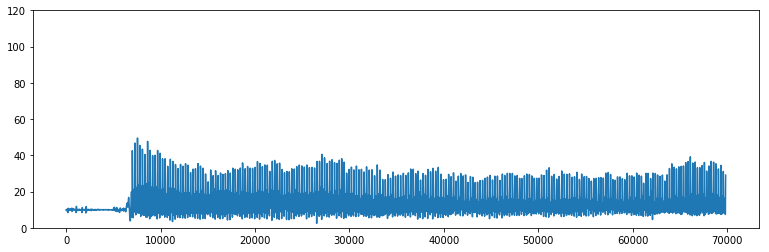

In [90]:
plt.figure(figsize=(13,4))
data = pd.read_csv(DIR[-1] + "/accelerometer.txt", names = ["user", "type", "t", "ax", "ay", "az"])
data["t"] = data["t"] - data["t"].iloc[0]
data["a"] = (data["ax"]**2 + data["ay"]**2 + data["az"]**2)**0.5
plt.plot(data["t"].iloc[0:7000],data["a"].iloc[0:7000])
plt.ylim(0,120)
plt.show()

In [93]:
data

,user,type,t,ax,ay,az,a
0,Alberto,Accelerometer,0,0.306458,2.308010,9.662998,9.939535
1,Alberto,Accelerometer,11,0.459687,2.317587,9.327810,9.622399
2,Alberto,Accelerometer,21,0.651223,2.346318,9.088389,9.408938
3,Alberto,Accelerometer,30,0.900220,2.585738,8.983045,9.391034
4,Alberto,Accelerometer,42,0.919373,2.767697,9.097966,9.553972
5,Alberto,Accelerometer,50,0.823605,2.806004,9.346964,9.793759
6,Alberto,Accelerometer,61,0.632069,2.758120,9.595961,10.004459
7,Alberto,Accelerometer,70,0.632069,2.595315,9.749189,10.108505
8,Alberto,Accelerometer,80,0.632069,2.451663,9.720459,10.044774
9,Alberto,Accelerometer,92,0.517148,2.451663,9.730036,10.047472
